In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from scipy.interpolate import griddata
import plotly
from plotly.graph_objs import *

from json_io import list_from_json

plotly.offline.init_notebook_mode()
plt.style.use("ggplot")

twitterDatasetSize = 215977
twitterFeatureSize = 3145772

redditDatasetSize = 745376
redditFeatureSize = 12490143

## Examples with randomly generated numbers

In [8]:
real_elem = np.random.randint(0, 30000, 200)
real_elem[0] = 0
real_elem[1] = 30000
real_elem[2] = 0
real_elem[3] = 30000
real_feat = np.random.randint(0, 100000, 200)
real_feat[0] = 0
real_feat[1] = 100000
real_feat[2] = 100000
real_feat[3] = 0
real_scores = np.random.rand(len(real_elem))
for i in range(0, 4):
    real_scores[i] = 0

print(real_elem.shape)
print(real_feat.shape)
print(real_scores.shape)

(200,)
(200,)
(200,)


In [9]:
def graphHeatmap(numSamplesList, numTopFeaturesList, scoresList, interpMethod,
                saGridMin=None, saGridMax=None, saGridStep=None, fGridMin=None, fGridMax=None, fGridStep=None):
    """
    plot a heatmap visualization of classification results and their interpolation, where interpolation points
    are determined by a bounded grid.
    
    For example: saGridMin=0, saGridMax=5000, saGridStep=25, fGridMin=0, fGridMax=1000, fGridStep=10
    Interpolation will occur at 200 * 100 = 20,000 points in a grid bounded by (0, 5000), (0, 1000) with samples step-size=25 and feature step-size=10
    
    (0,0)   , (0, 10)  , (0, 20)  , ... (0, 990)
    (25,0)  , (25, 10) , (25, 20) , ... (25, 990)   
    .
    .
    .
    (4975,0), (4975,10), (4975,20), ... (4975, 990)
    
    Parameters ------
    numSamplesList: array-like 
        array where when flattened, ith element corresponds to number of samples used during ith train/test evaluation
    numTopFeaturesList: array-like
        array where when flattened, ith element corresponds to number of top features used during ith train/test evaluation
    scoresList: array-like
        array where when flattened, ith element corresponds to classifier score on dataset using numSamplesList[i] samples
        and top numTopFeaturesList[i] features
    interpMethod: string (optional)
        one of "nearest", "linear", or "cubic". If not none, will perform 3D interpolation using scipy.interpolate.griddata with specified interpolation method
    saGridMin: int
        first point to interpolate samples at 
    saGridMax: int
        last point to interpolate samples at
    saGridStep: int
        step-size for samples interpolation
    fGridMin: int
        first point to interpolate top features at
    fGridMax: int
        last point to interpolate top features at
    fGridStep: int
        step-size for top features interpolation
    """
    
    flattenedSamples = np.ravel(numSamplesList)
    flattenedFeats = np.ravel(numTopFeaturesList)
    flattenedScores = np.ravel(scoresList)
    
    maxSamples, maxFeats, maxScore = bestParams(flattenedSamples, flattenedFeats, flattenedScores)
    
    gridSamples, gridFeats = np.mgrid[saGridMin:saGridMax:saGridStep, fGridMin:fGridMax:fGridStep]
    gridScores = griddata((flattenedSamples, flattenedFeats), flattenedScores, (gridSamples, gridFeats), method=interpMethod)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(maxSamples, maxFeats, "ro", ms=5, label="Max accuracy: {} achieved w/ {} samples and top {} features".format(round(maxScore, 4), maxSamples, maxFeats))
    heatmap = ax.pcolor(gridSamples, gridFeats, gridScores)
    cBar = fig.colorbar(heatmap)
    cBar.ax.set_title("accuracy", fontsize=10)
    cBar.set_ticks(np.linspace(0, 1, 11))

    ax.set_title("Top k features of n sample dataset vs. classification accuracy", fontsize=12, y=1.10)
    ax.set_xlabel("# samples")
    ax.set_ylabel("# top features")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
    plt.subplots_adjust(bottom=.3)

<IPython.core.display.Javascript object>


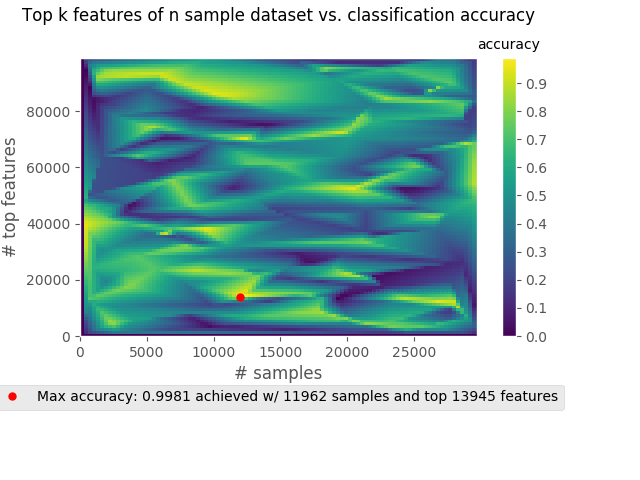

In [10]:
graphHeatmap(real_elem, real_feat, real_scores, interpMethod="linear", saGridMin=0, saGridMax=30000, saGridStep=300, fGridMin=0, fGridMax=100000, fGridStep=1000)

In [11]:
def graph3D(numSamplesList, numTopFeaturesList, scoresList, interpMethod="none",
            saGridMin=None, saGridMax=None, saGridStep=None, fGridMin=None, fGridMax=None, fGridStep=None):
    """
    plot a 3D visualization of classification results, and optionally an interpolated view where interpolation points
    are determined by a bounded grid.
    
    For example: saGridMin=0, saGridMax=5000, saGridStep=25, fGridMin=0, fGridMax=1000, fGridStep=10
    Interpolation will occur at 200 * 100 = 20,000 points in a grid bounded by (0, 5000), (0, 1000) with samples step-size=25 and feature step-size=10
    
    (0,0)   , (0, 10)  , (0, 20)  , ... (0, 990)
    (25,0)  , (25, 10) , (25, 20) , ... (25, 990)   
    .
    .
    .
    (4975,0), (4975,10), (4975,20), ... (4975, 990)
    
    Parameters ------
    numSamplesList: array-like 
        array where when flattened, ith element corresponds to number of samples used during ith train/test evaluation
    numTopFeaturesList: array-like
        array where when flattened, ith element corresponds to number of top features used during ith train/test evaluation
    scoresList: array-like
        array where when flattened, ith element corresponds to classifier score on dataset using numSamplesList[i] samples
        and top numTopFeaturesList[i] features
    interpMethod: string (optional)
        one of "none", "nearest", "linear", or "cubic". If not none, will perform 3D interpolation using scipy.interpolate.griddata with specified interpolation method
    saGridMin: int
        first point to interpolate samples at 
    saGridMax: int
        last point to interpolate samples at
    saGridStep: int
        step-size for samples interpolation
    fGridMin: int
        first point to interpolate top features at
    fGridMax: int
        last point to interpolate top features at
    fGridStep: int
        step-size for top features interpolation
    """
    
    flattenedSamples = np.ravel(numSamplesList)
    flattenedFeats = np.ravel(numTopFeaturesList)
    flattenedScores = np.ravel(scoresList)
    
    maxSamples, maxFeats, maxScore = bestParams(flattenedSamples, flattenedFeats, flattenedScores)
    
    fig = plt.figure()
    fig.suptitle("Top k features of n sample dataset vs. classification accuracy", fontsize=14)
    
    if interpMethod != "none":
        gridSamples, gridFeats = np.mgrid[saGridMin:saGridMax:saGridStep, fGridMin:fGridMax:fGridStep]
        gridScores = griddata((flattenedSamples, flattenedFeats), flattenedScores, (gridSamples, gridFeats), method=interpMethod)
        
        fig.set_size_inches(10,4)
        ax = fig.add_subplot(121, projection='3d')
        ax.scatter(flattenedSamples, flattenedFeats, flattenedScores, s=10, alpha=.5)
        ax.scatter(maxSamples, maxFeats, maxScore, c='blue', s=15)
        ax.set_xlabel("# samples")
        ax.set_ylabel("# top features")
        ax.set_zlabel("accuracy")
        ax.tick_params(axis='both', which='major', labelsize=8)
        
        ax = fig.add_subplot(122, projection='3d')
        ax.scatter(gridSamples, gridFeats, gridScores, s=.5, alpha=.1)
        ax.scatter(maxSamples, maxFeats, maxScore, c='blue', s=15, label="Max accuracy: {} achieved w/ {} samples and top {} features".format(round(maxScore, 4), maxSamples, maxFeats))
        ax.set_xlabel("# samples")
        ax.set_ylabel("# top features")
        ax.set_zlabel("accuracy")
        ax.set_title("Interpolated", fontsize=10, y=1.07)
        ax.tick_params(axis='both', which='major', labelsize=8)
        
        ax.legend(loc='upper center', bbox_to_anchor=(-0.15, -0.15))
        plt.subplots_adjust(bottom=.2)
        
    else:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(flattenedSamples, flattenedFeats, flattenedScores, s=10, alpha=.5)
        ax.scatter(maxSamples, maxFeats, maxScore, c='blue', s=15, label="Max accuracy: {} achieved w/ {} samples and top {} features".format(round(maxScore, 4), maxSamples, maxFeats))
        ax.set_xlabel("# samples")
        ax.set_ylabel("# top features")
        ax.set_zlabel("accuracy")
        ax.tick_params(axis='both', which='major', labelsize=8)
        
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
        plt.subplots_adjust(bottom=.2)
    

<IPython.core.display.Javascript object>


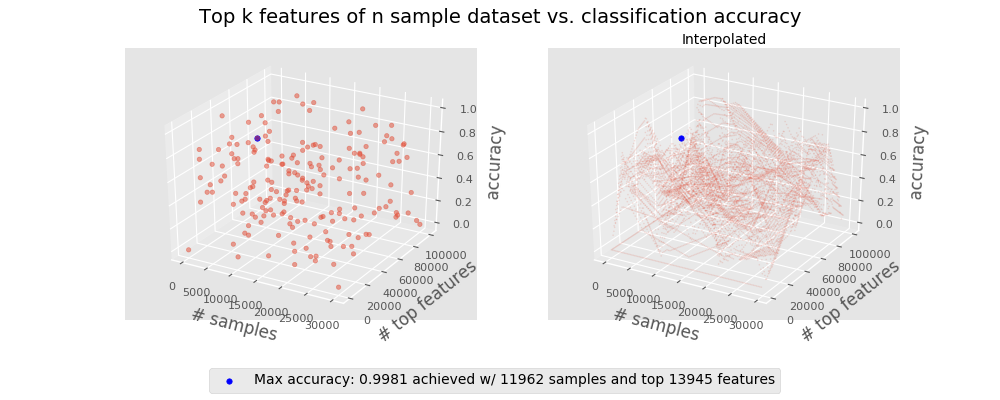

In [12]:
graph3D(real_elem, real_feat, real_scores, interpMethod="linear", saGridMin=0, saGridMax=30000, saGridStep=300, fGridMin=0, fGridMax=100000, fGridStep=1000)

In [3]:
def bestParams(numSamplesList, numTopFeaturesList, scoresList):
    """
    return a 3-tuple (samples, topFeatures, score) corresponding to the parameters that resulted in highest score
    
    Parameters ------
    numSamplesList: array-like 
        array where when flattened, ith element corresponds to number of samples used during ith train/test evaluation
    numTopFeaturesList: array-like
        array where when flattened, ith element corresponds to number of top features used during ith train/test evaluation
    scoresList: array-like
        array where when flattened, ith element corresponds to classifier score on dataset using numSamplesList[i] samples
        and top numTopFeaturesList[i] features
    """
    
    flattenedSamples = np.ravel(numSamplesList)
    flattenedFeat = np.ravel(numTopFeaturesList)
    flattenedScores = np.ravel(scoresList)
    
    assert(len(flattenedSamples) == len(flattenedFeat) and len(flattenedSamples) == len(flattenedScores)),\
    "Size mismatch: numTopFeaturesList: length {}\tnumSamplesList: length {}\tscoresList: length {}"\
    .format(len(flattenedSamples), len(flattenedFeat), len(flattenedScores))
    
    argMax = np.argmax(flattenedScores)
    return (flattenedSamples[argMax], flattenedFeat[argMax], flattenedScores[argMax])
    

In [23]:
def graph3DfromJSON(jsonPath, datasetSize, featuresSize, colorscale="Jet", scatter=False):
    """
    3D visualization of classification results read from a JSON file
    
    Parameters -------------
    
    jsonPath: string
        path to json file w/ classification results.
        Expected format:
        [
            [# top features, % of dataset used, accuracy],
            ...
        ]
        Ex: Two runs, first using top 10000 features of training set of size 50% of total dataset, 85% classification accuracy
        second using top 20000 features of training set of size 80% of total dataset, 91% classification accuracy
        [
            [10000, .5, .85],
            [20000, .8, .91]
        ]
    datasetSize: int
        total size of dataset
    featuresSize: int
        total number of features
    colorscale: string
        color scale for 3D visualization. See plotly documentation for supported colormaps
    scatter: (optional, default=False) bool
        plot actual data points overlayed on surface
        
    """
    
    (feat, size, acc) = zip(*list_from_json(jsonPath))

    # used for plotting actual data as scatter points
    feat = [featuresSize if x == 0 else x for x in feat]
    size = [datasetSize * x for x in size]
    acc = np.array([x for x in acc])
    
    best_samp, best_feat, best_acc = bestParams(size, feat, acc)

    # used for plotting surface
    feats = np.unique(feat)[::-1]
    sizes = np.unique(size)
    accs = np.reshape(acc, (len(feats), len(sizes)))
    
    text = np.reshape(np.array(["feat: {} size: {} accuracy: {}".format(f, s, a) for (f, s, a) in zip(feat, size, acc)]), (len(feats), len(sizes)))
    
    data = [
        Surface(
            x=sizes,
            y=feats,
            z=accs,
            colorscale=colorscale,
            hoverinfo="text",
            text=text
        ),
        Scatter3d(
            x=[best_samp],
            y=[best_feat],
            z=[best_acc],
            name="Best params",
            marker = dict(
                size = 10,
                color = 'rgba(0, 255, 0, .8)',
            ),
            hoverinfo="text",
            text=["feat: {} size: {} accuracy: {}".format(best_feat, best_samp, best_acc)]
        )
    ]
    
    if scatter:
        data.append(
            Scatter3d(
                x=size,
                y=feat,
                z=acc,
            )
        )
    
    layout = Layout(
        title='The relationship between total features, training size, and accuracy',
        autosize=True,
        width=850,
        height=750,
        scene=dict(
            xaxis=dict(
                title="training size",
                type='log'),
            yaxis=dict(
                title="total features",
                type='log'),
            zaxis=dict(
                title="accuracy",
                range=[0, 1]
                )
        )
    )
    fig = Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

In [24]:
graph3DfromJSON("-twitter-reduction-trainsize-accuracy-mnbayes.json", twitterDatasetSize, twitterFeatureSize)

In [22]:
graph3DfromJSON("-reddit-reduction-trainsize-accuracy-mnbayes.json", redditDatasetSize, redditFeatureSize)